#### Resources:
- Paul Centore - A Zonohedral Approach to Optimal Colours
(https://legacy.sites.fas.harvard.edu/~cs278/papers/zone.pdf)
- Jessica Lee - Theory of Human Tetrachromatic Color Experience and Printing (https://imjal.github.io/theory-of-tetrachromacy/static/pdfs/Lee_TheoryofTet_v1.pdf)

#### Instructions:
Make sure to install Jessica's repository as a Python package using the line below. It requires Python 3.11.

In [6]:
!pip install -q git+https://github.com/VarunNSrivastava/ChromaLab

In [1]:
from chromalab.observer import Observer
from chromalab.spectra import Spectra, Illuminant
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import matplotlib.animation as animation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from tqdm import tqdm
from colour import sd_to_XYZ, XYZ_to_xy, XYZ_to_sRGB
from scipy.spatial import ConvexHull, Delaunay
%matplotlib widget

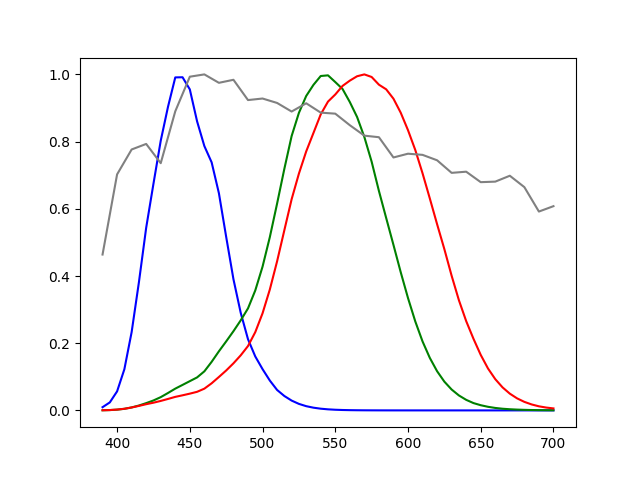

In [2]:
# Cone responses of a typical trichromat.
fig, ax = plt.subplots()
wavelengths = np.arange(390, 701, 5)
n = len(wavelengths)
standard_trichromat = Observer.trichromat(wavelengths)
illuminant = Illuminant.get("D65").interpolate_values(wavelengths)

standard_trichromat.sensors[0].plot(color="blue")
standard_trichromat.sensors[1].plot(color="green")
standard_trichromat.sensors[2].plot(color="red")
illuminant.plot(color="gray")

plt.show()

In [3]:
# Each point has an indicator reflectance function where R = 1 at a single wavelength and 0 elsewhere.
# These points can be thought of as vectors which form a (linearly dependent) basis.
# The Minkowski sum of these vectors span the object color solid.
# Each point in the solid can be represented as some (non-unique) linear combination of these vectors.
# This represents equations (9), (10), (11), (12), (13).
lms_responses = np.vstack((standard_trichromat.sensors[2].data, 
                           standard_trichromat.sensors[1].data, 
                           standard_trichromat.sensors[0].data)) * illuminant.data
lms_responses /= lms_responses.sum(axis=1, keepdims=True)

# Uses ideas from Jessica's paper, on chapter 3.2 The Max Basis.
# We use the cutpoints that Jessica shows to be optimal for the trichromatic case.
cutpoint_1 = 487
cutpoint_2 = 573
index_1 = None
index_2 = None
for i, wavelength in enumerate(wavelengths):
    if index_1 is None and wavelength > cutpoint_1:
        index_1 = i
    if index_2 is None and wavelength >= cutpoint_2:
        index_2 = i
        break

# We calculate the vectors p1, p2 and p3 as shown in the paper.
# We "project the partition into the cone response basis" by summing up all the lms_responses within each partition.
# Note that our earlier calculations for lms_responses includes the illuminant already.
p1 = np.sum(lms_responses[:, :index_1], axis=1).reshape((3, 1))
p2 = np.sum(lms_responses[:, index_1:index_2], axis=1).reshape((3, 1))
p3 = np.sum(lms_responses[:, index_2:], axis=1).reshape((3, 1))

# We then create a transformation matrix that maps p1 to (1, 0, 0), p2 to (0, 1, 0) and p3 to (1, 0, 0).
# p1, p2 and p3 correspond to the ideal R, G, B points on our object color solid, 
# and we are mapping them onto the R, G, B points on the RGB cube.
# We are essentially "stretching" our object color solid so that it approximates the RGB cube.
max_basis_transformation = np.linalg.inv(np.hstack((p1, p2, p3)))
points = np.matmul(max_basis_transformation, lms_responses).T

In [4]:
# lms_to_xyz_transformation = np.array([[1.94735469, -1.41445123, 0.36476327],
#                                       [0.68990272, 0.34832189, 0],
#                                       [0, 0, 1.93485343]])
lms_to_xyz_transformation = np.array([[1.94735469, -1.41445123, 0.36476327],
                                      [0.68990272, 0.34832189, -0.03828018],
                                      [0.0, 0.0, 1.0]])
xyz_to_rgb_transformation = np.array([[3.2406, -1.5372, -0.4986],
                                      [-0.9689, 1.8758, 0.0415],
                                      [0.0557, -0.2040, 1.0570]])
def gamma_correct(rgb):
    rgb_corrected = np.where(
        rgb <= 0.0031308,
        12.92 * rgb,
        1.055 * np.power(rgb, 1 / 2.4) - 0.055
    )
    return rgb_corrected
    
# Converts from max basis LMS coordinates to XYZ coordinates.
def lms_to_xyz(lms):
    return lms_to_xyz_transformation @ np.linalg.inv(max_basis_transformation) @ lms

def xyz_to_rgb(xyz):
    return gamma_correct(np.clip(xyz_to_rgb_transformation @ xyz, 0, 1))

# Getting the Object Color Solid

In [5]:
# As shown in Centore's paper, these vertices form the shape of the solid.
# This represents the matrix in (7).
vertices = np.zeros((n + 1, n, 3))
for i in range(1, n + 1):
    for j in range(n):
        vertices[i, j] = vertices[i - 1, j] + points[(i + j - 1) % n]

# This represents the diagram in (8)
faces = np.zeros((n * (n - 1), 4, 3))
face_colors = np.zeros((n * (n - 1), 3))
for i in range(1, n):
    for j in range(n):
        faces[((i - 1) * n) + j, 0] = vertices[i, j]
        faces[((i - 1) * n) + j, 1] = vertices[i - 1, (j + 1) % n]
        faces[((i - 1) * n) + j, 2] = vertices[i, (j + 1) % n]
        faces[((i - 1) * n) + j, 3] = vertices[i + 1, j]
        face_colors[(i - 1) * n + j] = xyz_to_rgb(lms_to_xyz(vertices[i, j]))

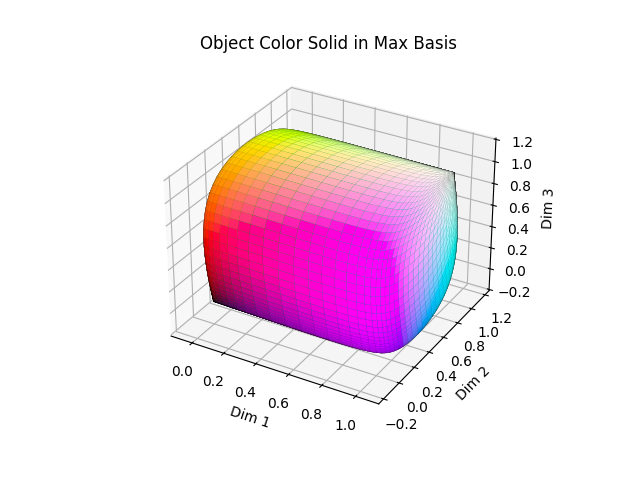

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
poly3d = Poly3DCollection(faces, linewidths=0.03, edgecolors='k')
poly3d.set_facecolor(face_colors)
ax.add_collection3d(poly3d)
ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.set_zlabel('Dim 3')
ax.set_title('Object Color Solid in Max Basis')
plt.show()

# Getting the Ostwald Slice

In [7]:
# Builds up the vertices from the set of generating vectors.
# Specifies the XYZ color coordinates of each vertex. 
# Note that the XYZ color space is linear.
vertices = np.zeros((n + 1, n, 3))
for i in range(1, n + 1):
    for j in range(n):
        vertices[i, j] = vertices[i - 1, j] + points[(i + j - 1) % n]

# Builds up the set of edges from the diagram in (8).
# There are 2 * (n ** 2) edges in total where n is the number of generating vectors.
# edges_xyz specifies the XYZ color coordinates of its two endpoints.
edges = np.zeros((2 * (n ** 2), 2, 3))
index = 0
for j in range(n):
    # Vertical edges.
    for i in range(n):
        edges[index][0] = vertices[i][j]
        edges[index][1] = vertices[i + 1][j]
        index += 1
        
    # Diagonal edges.
    for i in range(1, n + 1):
        edges[index][0] = vertices[i][j]
        edges[index][1] = vertices[i - 1][(j + 1) % n]
        index += 1

In [8]:
# Iterates through each edge and checks whether it intersects the plane.
# If it does, store the coordinates of the intersection and the XYZ color coordinates of the intersection.
# The XYZ color coordinates is obtained from taking a linear combination of the XYZ color coordinates of its endpoints.
intersection_points = []
# ax + by + cz + d = 0
a = 0.7
b = 0.4
c = 0.9
d = -0.8
for i in range(edges.shape[0]):
    p1 = edges[i][0]
    p2 = edges[i][1]
    v = p2 - p1
    denom = a * v[0] + b * v[1] + c * v[2]
    if abs(denom) < 1e-6:    # Edge is parallel to plane.
        continue
    t = -(d + a * p1[0] + b * p1[1] + c * p1[2]) / denom
    if 0 <= t <= 1:
        i_point = ((1 - t) * p1) + (t * p2)
        intersection_points.append(i_point)
assert len(intersection_points) > 0, "No intersection points"
intersection_rgb = [xyz_to_rgb(lms_to_xyz(i_point)) for i_point in intersection_points]

# In the end, we obtain an array of points along the boundary of the intersection and their RGB values.
intersection_points = np.array(intersection_points)
intersection_rgb = np.array(intersection_rgb)

In [9]:
# We then connect these vertices together to form the outline of the intersection.
# We do this by first projecting the points onto the 2D plane and then finding the convex hull of the points.
# We then connect adjacent vertices with edges.
def find_orthogonal_vectors(normal):
    n = normal / np.linalg.norm(normal)
    # Create a vector that is not collinear with the normal
    if n[0] == 0 and n[1] == 0:
        arbitrary_vector = np.array([1, 0, 0])
    else:
        arbitrary_vector = np.array([0, 0, 1])
    vec_a = np.cross(n, arbitrary_vector)
    vec_a /= np.linalg.norm(vec_a)
    vec_b = np.cross(n, vec_a)
    vec_b /= np.linalg.norm(vec_b)
    return vec_a, vec_b
vec_a, vec_b = find_orthogonal_vectors(np.array([a, b, c]))
projection_matrix = np.vstack((vec_a, vec_b))
projected_intersection_points = np.matmul(projection_matrix, intersection_points.T).T
hull = ConvexHull(projected_intersection_points)
boundary_edges = []
boundary_colors = []
for i in range(len(hull.vertices)):
    current_index = hull.vertices[i]
    next_index = hull.vertices[(i + 1) % len(hull.vertices)]  # Wraparound for cyclic connection
    boundary_edges.append([intersection_points[current_index], intersection_points[next_index]])
    boundary_colors.append(intersection_rgb[current_index])
boundary_edges = np.array(boundary_edges)
boundary_color = np.array(boundary_colors)

In [10]:
density = 200
if c != 0:
    x = np.linspace(np.min(boundary_edges[:, :, 0]), np.max(boundary_edges[:, :, 0]), density)
    y = np.linspace(np.min(boundary_edges[:, :, 1]), np.max(boundary_edges[:, :, 1]), density)
    X, Y = np.meshgrid(x, y)
    Z = -(a * X + b * Y + d) / c
elif b != 0:
    x = np.linspace(np.min(boundary_edges[:, :, 0]), np.max(boundary_edges[:, :, 0]), density)
    z = np.linspace(np.min(boundary_edges[:, :, 2]), np.max(boundary_edges[:, :, 2]), density)
    X, Z = np.meshgrid(x, z)
    Y = -(a * X + c * Z + d) / b
elif a != 0:
    y = np.linspace(np.min(boundary_edges[:, :, 1]), np.max(boundary_edges[:, :, 1]), density)
    z = np.linspace(np.min(boundary_edges[:, :, 2]), np.max(boundary_edges[:, :, 2]), density)
    Y, Z = np.meshgrid(y, z)
    X = -(b * Y + c * Z + d) / a
else:
    raise ValueError

points = np.column_stack((X.ravel(), Y.ravel(), Z.ravel()))
projected_points = points @ projection_matrix.T
delaunay = Delaunay(projected_intersection_points)
inside_mask = delaunay.find_simplex(projected_points) >= 0
X_inside = X[inside_mask.reshape(X.shape)]
Y_inside = Y[inside_mask.reshape(Y.shape)]
Z_inside = Z[inside_mask.reshape(Z.shape)]
points_inside = np.column_stack((X_inside, Y_inside, Z_inside))
square_colors = np.zeros((points_inside.shape[0], 3))
for i in range(square_colors.shape[0]):
    square_colors[i] = xyz_to_rgb(lms_to_xyz(points_inside[i]))

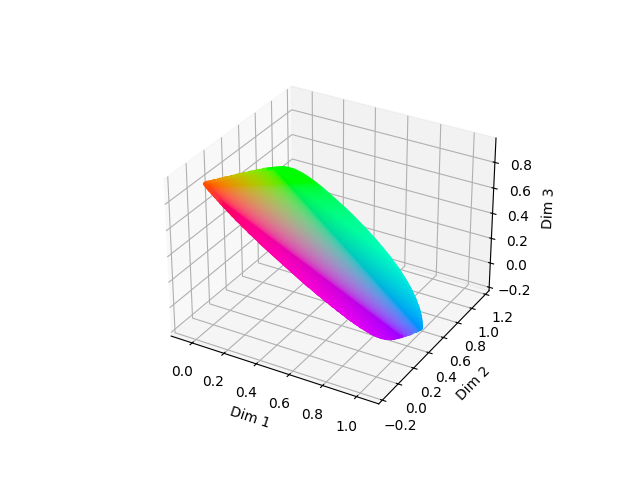

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# scatter = ax.scatter(intersection_points[:, 0], intersection_points[:, 1], intersection_points[:, 2], c=intersection_rgb, s=20)

start = boundary_edges[:, 0, :]
direction = boundary_edges[:, 1, :] - boundary_edges[:, 0, :]
ax.quiver(start[:, 0], start[:, 1], start[:, 2], direction[:, 0], direction[:, 1], direction[:, 2], color=boundary_color, linewidths=2, arrow_length_ratio=0.0)

# ax.plot_surface(X, Y, Z, facecolors=square_colors, rstride=1, cstride=1, shade=False)
# ax.plot_trisurf(X_inside, Y_inside, Z_inside, color=square_colors, edgecolor='none
scatter = ax.scatter(X_inside, Y_inside, Z_inside, c=square_colors, s=3)

ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.set_zlabel('Dim 3')
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 180/180 [01:52<00:00,  1.59it/s]


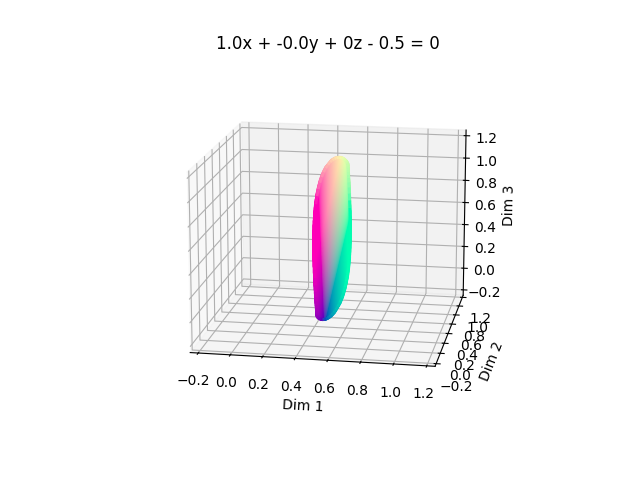

In [50]:
video_filename = 'object_slicing.mp4'
writer = animation.FFMpegWriter(fps=30)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

with writer.saving(fig, video_filename, dpi=400):
    count = 1
    total = 180
    for t in tqdm(np.linspace(0, 2 * np.pi, total)):
        # ax + by + cz + d = 0
        
        # Ostwald slices
        # a = ((1 / np.sqrt(2)) * np.cos(t)) - ((1 / np.sqrt(6)) * np.sin(t))
        # b = ((-1 / np.sqrt(2)) * np.cos(t)) - ((1 / np.sqrt(6)) * np.sin(t))
        # c = ((2 / np.sqrt(6)) * np.sin(t))
        # d = 0

        # Slice along an axis
        a = np.cos(t)
        b = np.sin(t)
        c = 0
        d = -0.5 * (a + b + c)
        
        intersection_points = []
        for i in range(edges.shape[0]):
            p1 = edges[i][0]
            p2 = edges[i][1]
            v = p2 - p1
            denom = a * v[0] + b * v[1] + c * v[2]
            if abs(denom) < 1e-6:    # Edge is parallel to plane.
                continue
            t = -(d + a * p1[0] + b * p1[1] + c * p1[2]) / denom
            if 0 <= t <= 1:
                i_point = ((1 - t) * p1) + (t * p2)
                intersection_points.append(i_point)
        assert len(intersection_points) > 0, "No intersection points"
        intersection_rgb = [xyz_to_rgb(lms_to_xyz(i_point)) for i_point in intersection_points]
        
        # In the end, we obtain an array of points along the boundary of the intersection and their RGB values.
        intersection_points = np.array(intersection_points)
        intersection_rgb = np.array(intersection_rgb)

        vec_a, vec_b = find_orthogonal_vectors(np.array([a, b, c]))
        projection_matrix = np.vstack((vec_a, vec_b))
        projected_intersection_points = np.matmul(projection_matrix, intersection_points.T).T
        hull = ConvexHull(projected_intersection_points)
        boundary_edges = []
        boundary_colors = []
        for i in range(len(hull.vertices)):
            current_index = hull.vertices[i]
            next_index = hull.vertices[(i + 1) % len(hull.vertices)]  # Wraparound for cyclic connection
            boundary_edges.append([intersection_points[current_index], intersection_points[next_index]])
            boundary_colors.append(intersection_rgb[current_index])
        boundary_edges = np.array(boundary_edges)
        boundary_color = np.array(boundary_colors)

        delaunay = Delaunay(projected_intersection_points)
        
        density = 200
        if max(abs(a), abs(b), abs(c)) == abs(c):
            x = np.linspace(np.min(boundary_edges[:, :, 0]), np.max(boundary_edges[:, :, 0]), density)
            y = np.linspace(np.min(boundary_edges[:, :, 1]), np.max(boundary_edges[:, :, 1]), density)
            X, Y = np.meshgrid(x, y)
            Z = -(a * X + b * Y + d) / (c + 10 ** (-6))
        elif max(abs(a), abs(b), abs(c)) == abs(b):
            x = np.linspace(np.min(boundary_edges[:, :, 0]), np.max(boundary_edges[:, :, 0]), density)
            z = np.linspace(np.min(boundary_edges[:, :, 2]), np.max(boundary_edges[:, :, 2]), density)
            X, Z = np.meshgrid(x, z)
            Y = -(a * X + c * Z + d) / (b + 10 ** (-6))
        elif max(abs(a), abs(b), abs(c)) == abs(a):
            y = np.linspace(np.min(boundary_edges[:, :, 1]), np.max(boundary_edges[:, :, 1]), density)
            z = np.linspace(np.min(boundary_edges[:, :, 2]), np.max(boundary_edges[:, :, 2]), density)
            Y, Z = np.meshgrid(y, z)
            X = -(b * Y + c * Z + d) / (a + 10 ** (-6))
        else:
            raise ValueError

        points = np.column_stack((X.ravel(), Y.ravel(), Z.ravel()))
        projected_points = points @ projection_matrix.T
        inside_mask = delaunay.find_simplex(projected_points) >= 0
        X_inside = X[inside_mask.reshape(X.shape)]
        Y_inside = Y[inside_mask.reshape(Y.shape)]
        Z_inside = Z[inside_mask.reshape(Z.shape)]
        points_inside = np.column_stack((X_inside, Y_inside, Z_inside))
        point_colors = xyz_to_rgb(lms_to_xyz(points_inside.T)).T

        ax.cla()  # Clear the previous plot
        
        start = boundary_edges[:, 0, :]
        direction = boundary_edges[:, 1, :] - boundary_edges[:, 0, :]
        ax.quiver(start[:, 0], start[:, 1], start[:, 2], direction[:, 0], direction[:, 1], direction[:, 2], color=boundary_color, linewidths=2, arrow_length_ratio=0.0)
        
        scatter = ax.scatter(X_inside, Y_inside, Z_inside, c=point_colors, s=3)

        ax.view_init(elev=15, azim=-80)
        ax.set_xlabel('Dim 1')
        ax.set_ylabel('Dim 2')
        ax.set_zlabel('Dim 3')
        ax.set_xlim([-0.25, 1.25])
        ax.set_ylim([-0.25, 1.25])
        ax.set_zlim([-0.25, 1.25])
        ax.set_title(f"{round(a, 2)}x + {round(b, 2)}y + {round(c, 2)}z - {abs(round(d, 2))} = 0")
        
        writer.grab_frame()
        count += 1

# Visualize slice for different plane equations

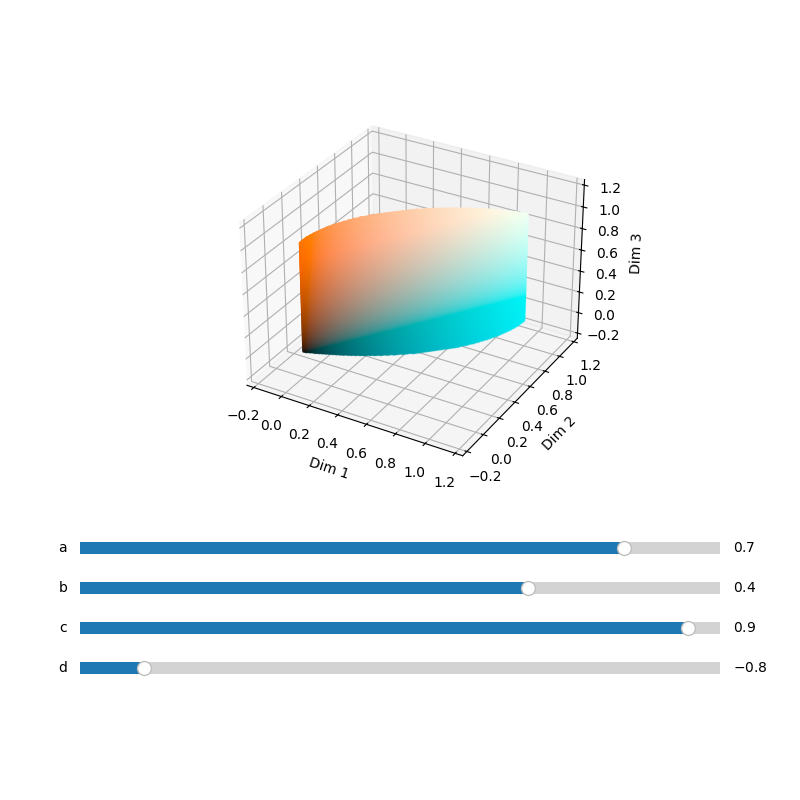

In [33]:
# This is an interactive slider where you can adjust the equation of the 2D plane and see how it intersects the solid. 
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
plt.subplots_adjust(bottom=0.4)

# poly3d = Poly3DCollection(faces, linewidths=0, edgecolors='k', alpha=0.2)
# poly3d.set_facecolor(face_colors)
# ax.add_collection3d(poly3d)

# Initial parameters
initial_a = 0.7
initial_b = 0.4
initial_c = 0.9
initial_d = -0.5

scatter = ax.scatter(X_inside, Y_inside, Z_inside, c=square_colors, s=3)

ax_a = plt.axes([0.1, 0.3, 0.8, 0.03], facecolor='lightgoldenrodyellow')
ax_b = plt.axes([0.1, 0.25, 0.8, 0.03], facecolor='lightgoldenrodyellow')
ax_c = plt.axes([0.1, 0.2, 0.8, 0.03], facecolor='lightgoldenrodyellow')
ax_d = plt.axes([0.1, 0.15, 0.8, 0.03], facecolor='lightgoldenrodyellow')

# Create sliders
a_slider = Slider(ax_a, 'a', -1.0, 1.0, valinit=initial_a, valstep=0.1)
b_slider = Slider(ax_b, 'b', -1.0, 1.0, valinit=initial_b, valstep=0.1)
c_slider = Slider(ax_c, 'c', -1.0, 1.0, valinit=initial_c, valstep=0.1)
d_slider = Slider(ax_d, 'd', -1.0, 1.0, valinit=initial_d, valstep=0.1)

# Update function to change the plot when any slider value changes
def update(val):
    intersection_points = []
    a = a_slider.val
    b = b_slider.val
    c = c_slider.val
    d = d_slider.val
    for i in range(edges.shape[0]):
        p1 = edges[i][0]
        p2 = edges[i][1]
        v = p2 - p1
        denom = a * v[0] + b * v[1] + c * v[2]
        if abs(denom) < 1e-6:    # Edge is parallel to plane.
            continue
        t = -(d + a * p1[0] + b * p1[1] + c * p1[2]) / denom
        if 0 <= t <= 1:
            i_point = ((1 - t) * p1) + (t * p2)
            intersection_points.append(i_point)
    if len(intersection_points) == 0:
        return
    intersection_rgb = [xyz_to_rgb(lms_to_xyz(i_point)) for i_point in intersection_points]
    intersection_points = np.array(intersection_points)
    intersection_rgb = np.array(intersection_rgb)

    def find_orthogonal_vectors(normal):
        n = normal / np.linalg.norm(normal)
        # Create a vector that is not collinear with the normal
        if n[0] == 0 and n[1] == 0:
            arbitrary_vector = np.array([1, 0, 0])
        else:
            arbitrary_vector = np.array([0, 0, 1])
        vec_a = np.cross(n, arbitrary_vector)
        vec_a /= np.linalg.norm(vec_a)
        vec_b = np.cross(n, vec_a)
        vec_b /= np.linalg.norm(vec_b)
        return vec_a, vec_b
    vec_a, vec_b = find_orthogonal_vectors(np.array([a, b, c]))
    projection_matrix = np.vstack((vec_a, vec_b))
    projected_intersection_points = np.matmul(projection_matrix, intersection_points.T).T
    hull = ConvexHull(projected_intersection_points)
    boundary_edges = []
    boundary_colors = []
    for i in range(len(hull.vertices)):
        current_index = hull.vertices[i]
        next_index = hull.vertices[(i + 1) % len(hull.vertices)]  # Wraparound for cyclic connection
        boundary_edges.append([intersection_points[current_index], intersection_points[next_index]])
        boundary_colors.append(intersection_rgb[current_index])
    boundary_edges = np.array(boundary_edges)
    boundary_color = np.array(boundary_colors)
    
    delaunay = Delaunay(projected_intersection_points)
    density = 200
    if max(a, b, c) == c:
        x = np.linspace(np.min(boundary_edges[:, :, 0]), np.max(boundary_edges[:, :, 0]), density)
        y = np.linspace(np.min(boundary_edges[:, :, 1]), np.max(boundary_edges[:, :, 1]), density)
        X, Y = np.meshgrid(x, y)
        Z = -(a * X + b * Y + d) / c
    elif max(a, b, c) == b:
        x = np.linspace(np.min(boundary_edges[:, :, 0]), np.max(boundary_edges[:, :, 0]), density)
        z = np.linspace(np.min(boundary_edges[:, :, 2]), np.max(boundary_edges[:, :, 2]), density)
        X, Z = np.meshgrid(x, z)
        Y = -(a * X + c * Z + d) / b
    elif max(a, b, c) == a:
        y = np.linspace(np.min(boundary_edges[:, :, 1]), np.max(boundary_edges[:, :, 1]), density)
        z = np.linspace(np.min(boundary_edges[:, :, 2]), np.max(boundary_edges[:, :, 2]), density)
        Y, Z = np.meshgrid(y, z)
        X = -(b * Y + c * Z + d) / a
    else:
        raise ValueError
    points = np.column_stack((X.ravel(), Y.ravel(), Z.ravel()))
    projected_points = points @ projection_matrix.T
    inside_mask = delaunay.find_simplex(projected_points) >= 0
    X_inside = X[inside_mask.reshape(X.shape)]
    Y_inside = Y[inside_mask.reshape(Y.shape)]
    Z_inside = Z[inside_mask.reshape(Z.shape)]
    points_inside = np.column_stack((X_inside, Y_inside, Z_inside))
    point_colors = xyz_to_rgb(lms_to_xyz(points_inside.T)).T

    scatter._offsets3d = (X_inside, Y_inside, Z_inside)
    scatter.set_color(point_colors)
    
    fig.canvas.draw_idle()  # Redraw the plot

# Connect the update function to each slider
a_slider.on_changed(update)
b_slider.on_changed(update)
c_slider.on_changed(update)
d_slider.on_changed(update)

ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.set_zlabel('Dim 3')

ax.set_xlim([-0.25, 1.25])
ax.set_ylim([-0.25, 1.25])
ax.set_zlim([-0.25, 1.25])

plt.show()

# Generate a single Ostwald slice

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

start = boundary_edges[:, 0, :]
direction = boundary_edges[:, 1, :] - boundary_edges[:, 0, :]
ax.quiver(start[:, 0], start[:, 1], start[:, 2], direction[:, 0], direction[:, 1], direction[:, 2], color=boundary_color, linewidths=2, arrow_length_ratio=0.0)

scatter = ax.scatter(X_inside, Y_inside, Z_inside, c=square_colors, s=3)
# Blue-pink: ax.view_init(elev=65, azim=160, roll=290), a = -0.51, b = -0.3, c = 0.81

ax.view_init(elev=65, azim=160, roll=290)

ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.set_zlabel('Dim 3')

plt.axis('off')
# plt.savefig("ostwald_red_blue.png", dpi=400)
plt.show()

# Visualize Ostwald slice at different viewing angles

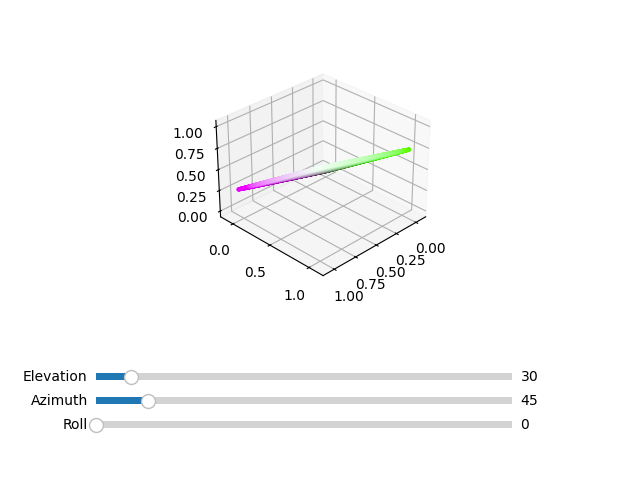

In [13]:
# Create figure and 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# surface = ax.plot_surface(X, Y, Z, cmap='viridis'),
scatter = ax.scatter(X_inside, Y_inside, Z_inside, c=square_colors, s=3)

# Set initial viewing angle
initial_elev = 30
initial_azim = 45
initial_roll = 0
ax.view_init(elev=initial_elev, azim=initial_azim, roll=initial_roll)

# Adjust layout to make space for sliders
plt.subplots_adjust(left=0.1, bottom=0.40)

# Add sliders for elevation and azimuth
ax_elev = plt.axes([0.15, 0.20, 0.65, 0.03], facecolor='lightgoldenrodyellow')
ax_azim = plt.axes([0.15, 0.15, 0.65, 0.03], facecolor='lightgoldenrodyellow')
ax_roll = plt.axes([0.15, 0.1, 0.65, 0.03], facecolor='lightgoldenrodyellow')

slider_elev = Slider(ax_elev, 'Elevation', 0, 360, valinit=initial_elev)
slider_azim = Slider(ax_azim, 'Azimuth', 0, 360, valinit=initial_azim)
slider_roll = Slider(ax_roll, 'Roll', 0, 360, valinit=initial_roll)

# Update function for sliders
def update(val):
    ax.view_init(elev=slider_elev.val, azim=slider_azim.val, roll=slider_roll.val)
    fig.canvas.draw_idle()  # Redraw the figure

# Connect sliders to update function
slider_elev.on_changed(update)
slider_azim.on_changed(update)
slider_roll.on_changed(update)

plt.show()

# Convert MP4 to GIF

In [51]:
import subprocess

# Step 1: Generate a color palette
subprocess.run([
    "ffmpeg", "-i", "object_slicing_x.mp4",
    "-vf", "fps=30,scale=1920:-1:flags=lanczos,palettegen",
    "-y", "palette.png"
])

# Step 2: Use the palette to create a high-quality GIF
subprocess.run([
    "ffmpeg", "-i", "object_slicing_x.mp4", "-i", "palette.png",
    "-lavfi", "fps=30,scale=1920:-1:flags=lanczos [x]; [x][1:v] paletteuse",
    "-y", "object_slicing_x.gif"
])

subprocess.run([
    "ffmpeg", "-i", "object_slicing_y.mp4",
    "-vf", "fps=30,scale=1920:-1:flags=lanczos,palettegen",
    "-y", "palette.png"
])

# Step 2: Use the palette to create a high-quality GIF
subprocess.run([
    "ffmpeg", "-i", "object_slicing_y.mp4", "-i", "palette.png",
    "-lavfi", "fps=30,scale=1920:-1:flags=lanczos [x]; [x][1:v] paletteuse",
    "-y", "object_slicing_y.gif"
])

subprocess.run([
    "ffmpeg", "-i", "object_slicing_z.mp4",
    "-vf", "fps=30,scale=1920:-1:flags=lanczos,palettegen",
    "-y", "palette.png"
])

# Step 2: Use the palette to create a high-quality GIF
subprocess.run([
    "ffmpeg", "-i", "object_slicing_z.mp4", "-i", "palette.png",
    "-lavfi", "fps=30,scale=1920:-1:flags=lanczos [x]; [x][1:v] paletteuse",
    "-y", "object_slicing_z.gif"
])

ffmpeg version 7.0.2 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.0.2_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex

CompletedProcess(args=['ffmpeg', '-i', 'object_slicing_z.mp4', '-i', 'palette.png', '-lavfi', 'fps=30,scale=1920:-1:flags=lanczos [x]; [x][1:v] paletteuse', '-y', 'object_slicing_z.gif'], returncode=0)